<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/13_minerva_CPC-UCI-backbone_pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/13_minerva_CPC-UCI-backbone_pretrain.ipynb)

# Pretraining backbones with Minerva CPC for HAR (Human Activity Recognition)

This notebook provides a demonstration of how to pretrain feature extraction backbones using the Minerva CPC model.
In particular, it walks through the process of training a Convolution + GRU as backbone on the "unlabeled" split of the UCI-HAR dataset.

## 1. Introduction

### 1.1 Objective

The main objective of this tutorial is to present how to employ Minerva CPC to pretrain a given backbone.

#### 1.1.1 Running this notebook from a terminal as a Python script.

You can convert this notebook into a Python script by executing the following command in your terminal:

```bash
jupyter nbconvert --to script 13_minerva_CPC-UCI-backbone_pretrain.ipynb
```

This will generate a Python script named `13_minerva_CPC-UCI-backbone_pretrain.py`, which you can then run directly from your terminal using:

```bash
python 13_minerva_CPC-UCI-backbone_pretrain.py
```

> **Note**: Before converting the notebook, you may want to adjust the main configuration variables found in the "Basic Setup" section to ensure they are appropriately set for your environment.

### 1.3 CPC

Contrastive Predictive Coding (CPC) is a self-supervised learning approach originally developed for image data and later adapted to the time series domain—such as in Human Activity Recognition (HAR).

The core idea is to split a time series into past and future segments. The model encodes the past portion and learns to predict encoded samples from the near future, without requiring explicit labels.

The original method was introduced in the paper “Representation Learning with Contrastive Predictive Coding”, available on arXiv (https://arxiv.org/abs/1807.03748).
The adaptation of CPC for HAR can be found in the paper “Contrastive Predictive Coding Based Feature Extraction for Human Activity Recognition" (https://arxiv.org/abs/2012.05333).

### 1.4 What we're going to cover

In this tutorial, we’ll demonstrate how to use the CPC model from the [Minerva framework](https://github.com/discovery-unicamp/Minerva) to train a backbone.
Specifically, we will train a backbone composed of a 1D Convolutional Neural Network (Conv1D) as the encoder module (g_enc), followed by a Gated Recurrent Unit (GRU) as the autoregressive module (g_ar), using the "unlabeled" split of the UCI-HAR dataset.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic Setup**](#sec_2) | Import useful modules (torch, torchvision, and lightning). |
| [**3. Setting up the Dataset**](#sec_3) | Set up the data download, the dataset and the data module for the traininig process. |
| [**4. Create the Model for the Pretext Task**](#sec_4) | Create the backbone, and the model for the pretext task. |
| [**5. Training the Model**](#sec_5) | Create a trainer object and train the model. |

### 1.5 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic Setup</a>

### 2.1 Setup main variables

Several variables influence the execution of this notebook, particularly in terms of memory usage and training time. These include:

* **`n_epochs`**: Specifies the maximum number of training epochs.

* **`checkpoint_every_n_epochs`**: Specifies how often, in terms of training epochs, a model checkpoint is saved.


* **`DL_BATCH_SIZE`**: Determines the batch size used during training.
    

* **`DL_NUM_WORKERS`**: Sets the number of worker threads used by the DataLoader for parallel data loading and preprocessing.

* **`monitor_backbone_performance_with_downstream_benchmark`**:  set to `True`, uses a downstream task benchmark to monitor the backbone’s performance.

You can customize these parameters in the following code cell.

In [1]:
# Total number of epochs for training the model using the SimCLR pretext task.
n_epochs = 20

# Number of epochs between model checkpoints
checkpoint_every_n_epochs = n_epochs // 5

# Dataloaders/Datamodule parameters
DL_BATCH_SIZE=64
DL_NUM_WORKERS=8

# Monitor the backbone performance using a downstream benchmark
monitor_backbone_performance_with_downstream_benchmark = False

### 2.2 Installing Lightining and Minerva modules

The code below attempts to import the Minerva module and will automatically install it if it is not already available.
> **Note**: Since Minerva depends on PyTorch Lightning, Lightning will also be installed automatically if it is not already present.

In [2]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 2.3 Importing basic modules

Let's import the basic modules, such as lightning, torch, minerva, and other utility modules.

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {lightning.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
Lightning version: 2.5.1


## <a id="sec_3">3. Setting up the Dataset</a>

We will use the unlabeled split of the UCI dataset to pretrain our backbone.

The UCI-HAR dataset is a Human Activity Recognition (HAR) dataset originally collected using a smartphone placed in a waist bag [1]. The version described here is a preprocessed variant of the original dataset.

The data adheres to the standardized format defined by the Daghar benchmark [2], though it omits the windowing process typically used in HAR pipelines.

It includes five activity classes: sitting, standing, walking, walking upstairs, and walking downstairs.

The dataset is structured into three directories: train, val, and test, which represent suggested splits for training, validation, and evaluation purposes.

Each directory contains a set of CSV files, with one file per user. Each file records accelerometer and gyroscope data, along with user information and an activity code. Each row represents a single time step, and the entire file captures a complete time series.

**References**

[1] A Public Domain Dataset for Human Activity Recognition using Smartphones
By D. Anguita, A. Ghio, L. Oneto, X. Parra, Jorge Luis Reyes-Ortiz. 2013
Published in The European Symposium on Artificial Neural Networks
URL 2: https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

[2] Napoli, O., Duarte, D., Alves, P. et al. A benchmark for domain adaptation and generalization in smartphone-based human activity recognition. Sci Data 11, 1192 (2024). https://doi.org/10.1038/s41597-024-03951-4
URL 2: https://www.nature.com/articles/s41597-024-03951-4

### 3.1 Downloading the dataset

We will download a version of the UCI-HAR dataset made available from my website.
The following code block downloads and unpacks the dataset into the `data/uci_pretrain` folder. 

In [4]:
import os
filename = 'uci_pretrain.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/uci_pretrain.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("data/uci_pretrain/"):
    # Unzip the checkpoint file
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

### 3.2 Instantiating the pretrain dataset

Next, we will instantiate the dataset using the `UCIHARDataset` class, which inherits from `torch.utils.data.Dataset` and was made available together with the dataset downloaded in the previous code block. 

This class is responsible for loading the UCI-HAR data in a format that is suitable for pretraining with the CPC model. 
It performs sliding window segmentation over the time series and allows configuration of several key parameters, window length (window), window stride, and the dataset split (split), which can be training, validation, or test.

It also provides options for using the dataset without labels (`return_only_features`), selecting specific input columns and the target label, and transposing the data when necessary to match the expected format of the machine learning models (e.g., convolutional networks).

In [5]:
from data.uci_pretrain.dataset import UCIHARDataset

# Parameters
dataset_path = "./data/uci_pretrain/"
window_sz = 60
window_stride = 30 # 50% of window overlap

# Pretrain datasets
train_dataset = UCIHARDataset(
            dataset_path=dataset_path,
            splits="train",
            window_sz=window_sz,
            window_stride=window_stride,
            transpose_data=True)

val_dataset = UCIHARDataset(
            dataset_path,
            splits="val",
            window_sz=window_sz,
            window_stride=window_stride,
            transpose_data=True)

class_names = train_dataset.classes

print(train_dataset)
print(val_dataset)

UCIHARDataset(paths=['./data/uci_pretrain/'], features.shape=(4839, 6, 60), labels.shape=(4839,), splits=['train'], window sz=60, window stride=30)
UCIHARDataset(paths=['./data/uci_pretrain/'], features.shape=(679, 6, 60), labels.shape=(679,), splits=['val'], window sz=60, window stride=30)


### 3.3 Inspecting samples from the dataset

In this section, we will inspect some samples from the dataset. 
First, we will define a function to visualize the samples.

Each sample consists of six time series, captured using the smartphone's accelerometer and gyroscope. 
The first three time series represent the x, y, and z axes of the accelerometer, while the last three correspond to the x, y, and z axes of the gyroscope.

The `plot_samples()` function will display these time series across two separate charts.

In [ ]:
def plot_sample(features, label, acc_min_max=None, gyr_min_max=None):
    plt.subplot(2, 1, 1)
    plt.title(f"Sample from class = {label}")
    plt.plot(features[0], label = "ACC-x")
    plt.plot(features[1], label = "ACC-y")
    plt.plot(features[2], label = "ACC-z")
    plt.ylabel("m/s²")
    if acc_min_max: plt.ylim(acc_min_max)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(features[3], label = "GYR-x")
    plt.plot(features[4], label = "GYR-y")
    plt.plot(features[5], label = "GYR-z")
    plt.ylabel("rad/s")
    plt.xlabel("Time step")
    if gyr_min_max: plt.ylim(gyr_min_max)
    plt.legend()
    plt.show()

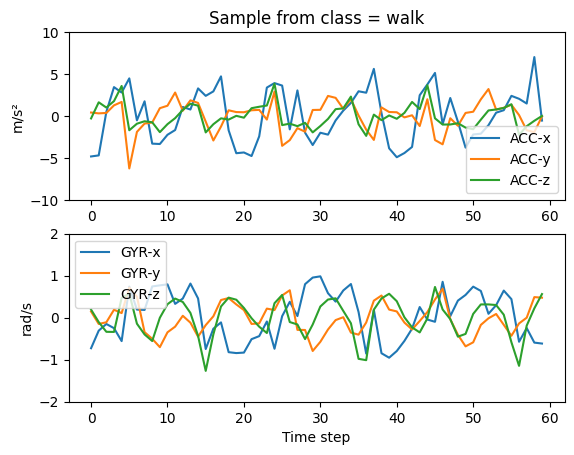

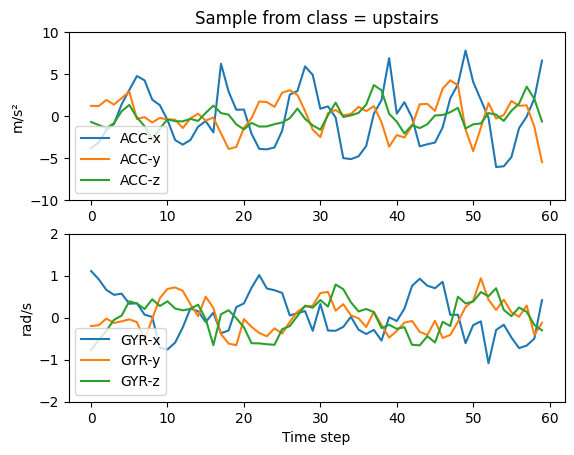

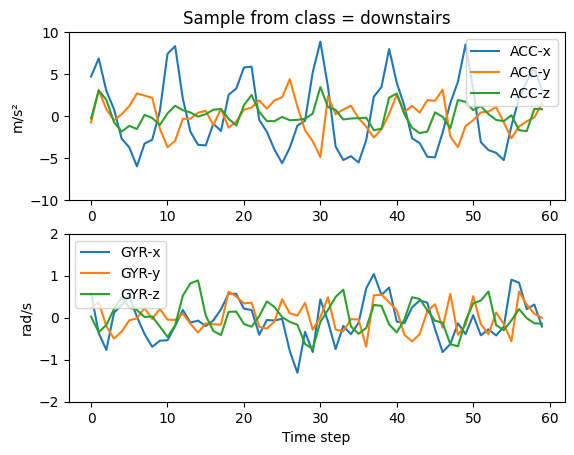

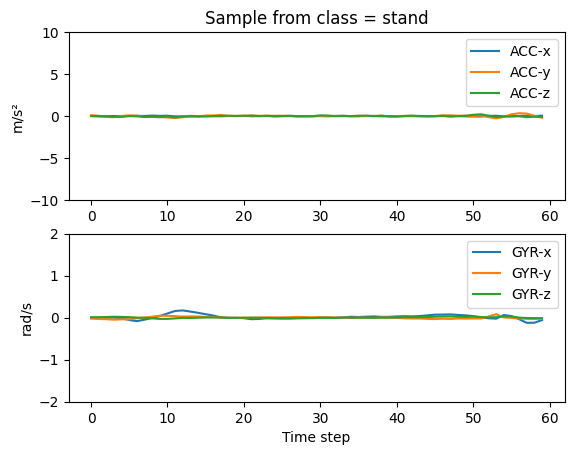

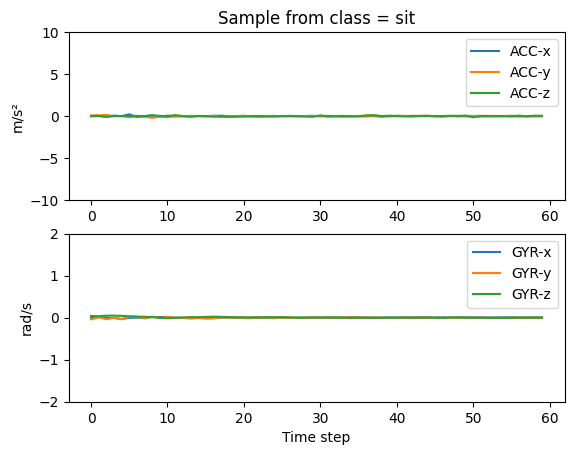

In [7]:
# Lets plot samples 0, 50, 100, 200 and 350
for i in [0, 50, 100, 200, 350]:
    plot_sample(train_dataset[i][0],               # Sample features
                class_names[train_dataset[i][1]],  # Sample label
                acc_min_max=(-10,10), 
                gyr_min_max=(-2,2))

We will use a `MinervaDataModule` to streamline data handling and simplify the training workflow.

In [8]:
from minerva.data.data_modules.base import MinervaDataModule

cpc_datamodule = MinervaDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_workers=DL_NUM_WORKERS,
    batch_size=DL_BATCH_SIZE,
    name="UCIHARDatamodule",
)

print(cpc_datamodule)

                 🆔 UCIHARDatamodule
└── Predict Split: test
📂 Datasets:
   ├── Train Dataset:
   │      UCIHARDataset(paths=['./data/uci_pretrain/'], features.shape=(4839, 6, 60), labels.shape=(4839,), splits=['train'], window sz=60, window stride=30)
   ├── Val Dataset:
   │      UCIHARDataset(paths=['./data/uci_pretrain/'], features.shape=(679, 6, 60), labels.shape=(679,), splits=['val'], window sz=60, window stride=30)
   └── Test Dataset:
          None

🛠 **Dataloader Configurations:**
   ├── Dataloader class: <class 'torch.utils.data.dataloader.DataLoader'>
   ├── Train Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: true
         ├── drop_last: false
   ├── Val Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: false
         ├── drop_last: false
   └── Test Dataloader Kwargs:
         ├── batch_size: 64
         ├── num_workers: 8
         ├── shuffle: false
         ├── drop_last: fa

## <a id="sec_4">4. Create the Model for the Pretext Task</a>

### 4.1 Backbone

The backbone consists of two encoder modules:  
- **g_enc**: responsible for spatial feature extraction, implemented as a 1D convolutional network (Convolutional1DEncoder).  
- **g_ar**: responsible for autoregressive modeling of the extracted representations, implemented as a Gated Recurrent Unit (HARCPCAutoregressive).  

Both components are imported directly from the Minerva framework.

In [9]:
from minerva.models.nets.cpc_networks import Convolutional1DEncoder, HARCPCAutoregressive

g_enc = Convolutional1DEncoder(input_size=6, kernel_size=3)

g_ar = HARCPCAutoregressive(input_size=128, hidden_size=256, batch_first=True, bidirectional=False)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 4.3 Building and Configuring the Model for the Pretext Task

Now we build and configure the model for the pretext task.

In [10]:
from minerva.models.ssl.cpc import CPC

cpc_model = CPC(
    g_enc=g_enc,
    g_ar=g_ar,
    prediction_head_in_channels=256, # Number of input channels for the prediction head
    prediction_head_out_channels=128, # Number of output channels for the prediction head
    num_steps_prediction=28, # Number of future steps to predict
    batch_size=64,
    minimum_steps=1, # Minimum number of steps for predictions
)

## <a id="sec_5">5. Training the Model</a>

As before, we’ll use a PyTorch Lightning `Trainer` object to handle the training process.

We will enhance the trainer by adding the following callbacks:

* **`ModelCheckpoint`**: to save model weights at regular intervals and also store the best-performing weights (based on the lowest validation loss).
  - We will also set `save_weights_only=True` to save only the model parameters (i.e., the backbone and projection head), excluding additional training states such as optimizer values and scheduler status.

Additionally, we will configure a `TensorBoardLogger` to log training metrics and store model checkpoints in the `logs/13_minerva_CPC_UCI/Pretext/` directory, where `N` corresponds to the number of epochs defined by the `n_epochs` variable.

The following code sets up the trainer along with these callbacks and logging configuration.

In [11]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

log_ckpt_dir=f"logs/13_minerva_CPC_UCI/Pretext/"
trainer = Trainer(max_epochs=n_epochs,
                  log_every_n_steps=16,
                  benchmark=True,
                  callbacks=[ModelCheckpoint(save_weights_only=True, save_last="link"),
                             ModelCheckpoint(save_weights_only=True, every_n_epochs=checkpoint_every_n_epochs, save_top_k=-1)],
                  logger = TensorBoardLogger(save_dir=log_ckpt_dir, name=f"CPC-conv-gru"))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now, let's call the `trainer.fit()` method to begin training the backbone.

In [12]:
# If you plan to monitor the backbone's performance with a downstream benchmark,
# do not run the trainer yet — wait for the next section.
if not monitor_backbone_performance_with_downstream_benchmark:
    trainer.fit(cpc_model, cpc_datamodule)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | g_enc      | Convolutional1DEncoder | 31.3 K | train
1 | g_ar       | HARCPCAutoregressive   | 691 K  | train
2 | predictors | ModuleList             | 921 K  | train
3 | softmax    | Softmax                | 0      | train
4 | lsoftmax   | LogSoftmax             | 0      | train
--------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.574     Total estimated model params size (M

Epoch 19: 100%|██████████| 76/76 [00:04<00:00, 15.99it/s, v_num=0]         

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 76/76 [00:04<00:00, 15.42it/s, v_num=0]
